In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.plotting import plot_simulation

# Clean imports (remove duplicates)
from utils.simulation import generate_simulation_data, SimulationParams
from utils.helpers import compute_metrics, map_labels_with_hungarian
from sklearn.decomposition import NMF
from models.admm import ADMM
from tools.rsa import compute_similarity
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df_clustering = pd.read_csv("../experiments/graph_clustering/outputs/graph_clustering.csv")
df_clustering[df_clustering["Dataset"] == "orl"]

# get median accuracy for each model
df_clustering.groupby(["Dataset", "Model"]).agg(
    {"Accuracy": ["mean", "std", "max", "min"]}
)


Accuracy                              
                            mean       std       max       min
Dataset       Model                                           
breast_cancer KMeans X  0.920914  0.000000  0.920914  0.920914
              NMF X     0.795149  0.017357  0.817223  0.720562
              SyNMF     0.940246  0.000000  0.940246  0.940246
digits        KMeans X  0.736667  0.059224  0.871452  0.571508
              NMF X     0.410395  0.050544  0.548692  0.272120
              SyNMF     0.860390  0.048444  0.890929  0.670006
iris          KMeans X  0.876200  0.168839  0.960000  0.513333
              NMF X     0.666400  0.070489  0.780000  0.366667
              SyNMF     0.559067  0.070865  0.960000  0.546667
mnist         KMeans X  0.495750  0.040978  0.597000  0.391000
              NMF X     0.409490  0.031096  0.490000  0.345000
              SyNMF     0.616520  0.040103  0.669000  0.553000
orl           KMeans X  0.593100  0.034614  0.677500  0.490000
              NMF X     0.366300  0.029089  0.440000  0.292500
              SyNMF     0.768375  0.018794  0.807500  0.712500
wine          KMeans X  0.915000  0.050354  0.932584  0.544944
              NMF X     0.764607  0.143439  0.943820  0.539326
              SyNMF     0.949438  0.000000  0.949438  0.949438

<Figure size 1200x600 with 0 Axes>

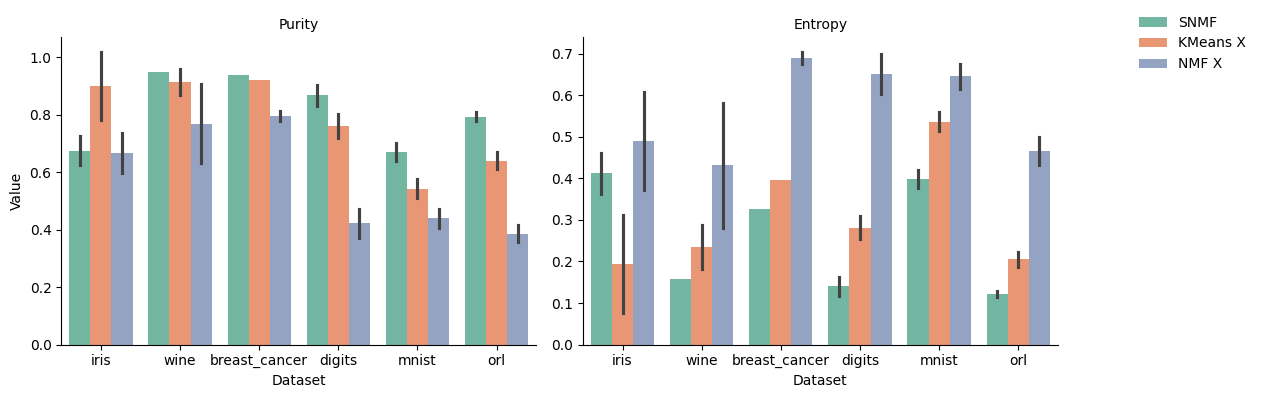

In [ ]:
# remove dataset haxby-faces if it exists
# df = df[df["Dataset"] != "haxby-faces"]
# df = df[df["Dataset"] != "diabetes"]

df_clustering = pd.read_csv("../experiments/graph_clustering/outputs/graph_clustering.csv")

df_clustering = df_clustering.drop(columns=["Accuracy"])
df_clustering["Model"] = df_clustering["Model"].replace("SyNMF", "SNMF")

# Melt the dataframe to have a long-form dataframe suitable for facetgrid
df_melted = df_clustering.melt(
    id_vars=["Dataset", "Model", "Seed"],
    value_vars=["Purity", "Entropy"],
    var_name="Metric",
    value_name="Value",
)

# Create a FacetGrid for the different metrics
plt.figure(figsize=(12, 6))
g = sns.FacetGrid(
    df_melted,
    col="Metric",
    sharey=False,
    height=4,
    aspect=1.2,
    col_wrap=2,
    sharex=False,
)
g.map_dataframe(
    sns.barplot, x="Dataset", y="Value", hue="Model", errorbar="sd", palette="Set2"
)

# Adjust the legend and labels
g.add_legend(bbox_to_anchor=(1.05, 1), loc="upper left")
g.set_axis_labels("Dataset", "Value")
g.set_titles(col_template="{col_name}")
plt.tight_layout()

# Save the plot to PDF
# plt.savefig("../results/plots/clustering.pdf", bbox_inches="tight", dpi=300)
# plt.close()
#


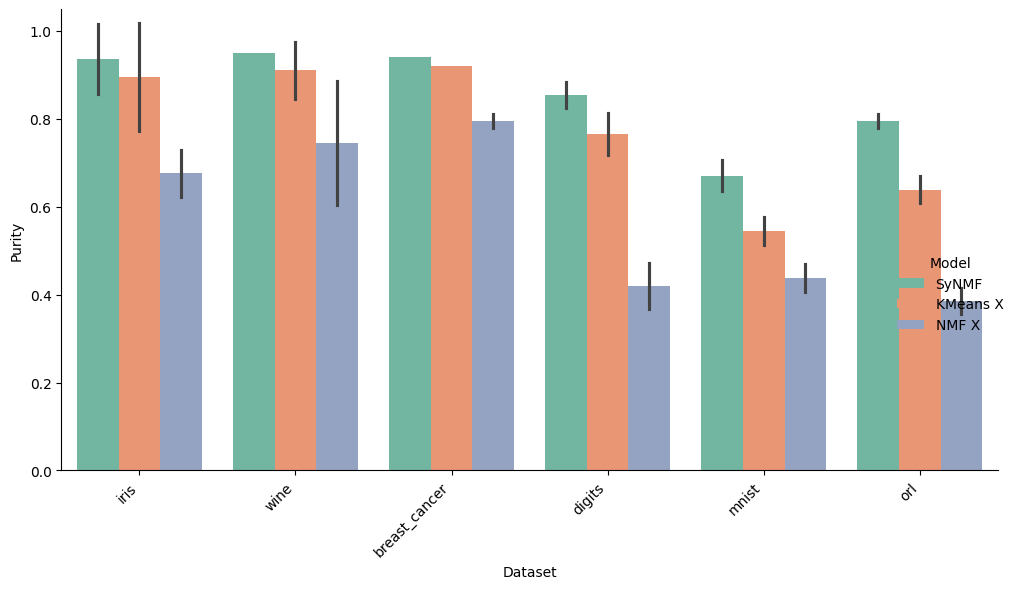

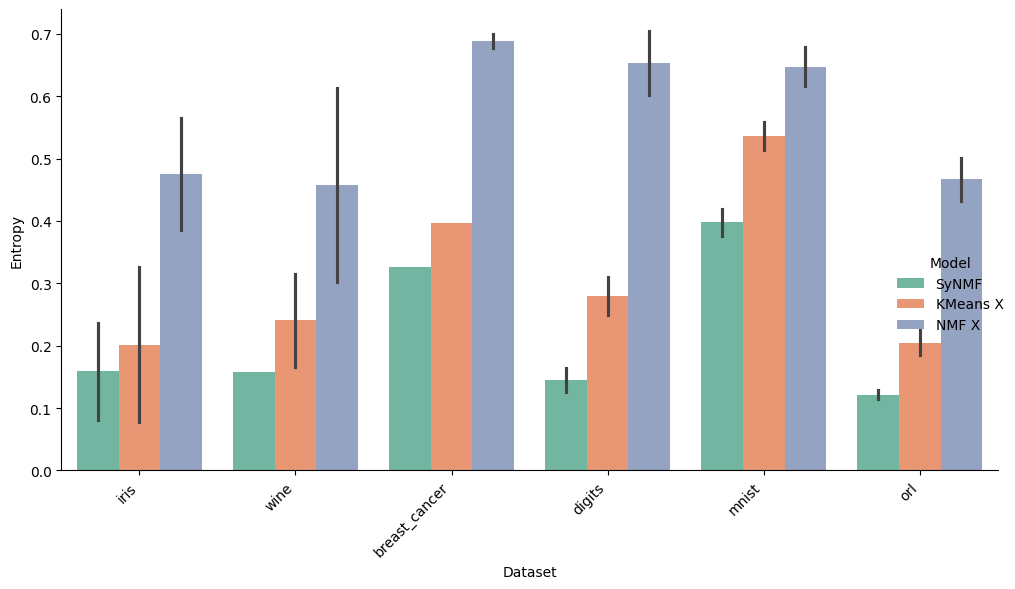

In [ ]:
# Create separate catplots for each metric
metrics_to_plot = ["Purity", "Entropy"]

for metric in metrics_to_plot:
    # Filter data for current metric
    df_metric = df_melted[df_melted["Metric"] == metric]

    # Create catplot
    g = sns.catplot(
        data=df_metric,
        x="Dataset",
        y="Value",
        hue="Model",
        kind="bar",  # Options: 'point', 'bar', 'strip', 'swarm', 'box', 'violin', 'boxen'
        height=6,
        aspect=1.5,
        palette="Set2",
        dodge=True,
        errorbar="sd",
        # capsize=0.1,
        # markers=['o', 's', '^', 'D'],
        # linestyles='',
        # markersize=8
    )

    # Alternative catplot options:
    # kind='bar' - for bar charts with error bars
    # kind='box' - for box plots
    # kind='violin' - for violin plots
    # kind='strip' - for strip plots (all points shown)
    # kind='swarm' - for swarm plots (non-overlapping points)

    g.set_axis_labels("Dataset", metric)

    # Rotate x-axis labels if needed
    g.set_xticklabels(rotation=45, ha="right")

    # Adjust legend
    # g._legend.set_frame_on(True)

    # Set y-axis limits for better visualization
    if metric == "Purity":
        g.set(ylim=(0, 1.05))
    elif metric == "Entropy":
        g.set(ylim=(0, None))

    # Add grid
    # g.map(plt.grid, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

    # Optional: Save high-quality figures
    # g.savefig(f'clustering_{metric.lower()}_catplot.pdf', dpi=300, bbox_inches='tight')
    # g.savefig(f'clustering_{metric.lower()}_catplot.png', dpi=300, bbox_inches='tight')


# Clustering to see how well this model actually works!

In [ ]:
# Configuration
SIMULATION_PARAMS = SimulationParams(
    n=150,
    k=10,
    p=150,
    snr=1.0,
    primary_concentration=1.0,
    base_concentration=0.1,
)

METRICS = ["ARI", "NMI", "Accuracy", "Entropy"]


def make_non_negative(data):
    """Shift data to be non-negative if needed."""
    return data - data.min() if data.min() < 0 else data


def create_models(k, seed, nmf_max_iter):
    """Create model configurations for clustering experiments."""
    return {
        "NMF X": {
            "model": NMF(
                n_components=k,
                init="random",
                solver="mu",
                random_state=seed,
                max_iter=nmf_max_iter,
                tol=0.0,
            ),
            "needs_similarity": False,
        },
        "SymNMF": {
            "model": ADMM(
                rank=k,
                max_outer=10,
                w_inner=100,
                tol=0.0,
                verbose=False,
                rho=1.0,
            ),
            "needs_similarity": True,
        },
    }


def prepare_data(X):
    """Prepare data for clustering models."""
    X_shifted = make_non_negative(X)
    S = compute_similarity(X, X, "linear")
    S = S - S.min()
    S = S / S.max()
    return X_shifted, S


def get_model_labels(model, data):
    """Extract cluster labels from a fitted model."""
    W = model.fit_transform(data)
    return np.argmax(W, axis=1)


def evaluate_single_experiment(noise_level, seed, nmf_max_iter):
    """Run clustering experiment for a single noise level and seed."""
    # Generate data
    SIMULATION_PARAMS.snr = noise_level
    SIMULATION_PARAMS.rng_state = seed
    X, M, _, _ = generate_simulation_data(SIMULATION_PARAMS)
    true_labels = np.argmax(M, axis=1)

    # Prepare data
    X_shifted, S = prepare_data(X)

    # Create models
    models = create_models(SIMULATION_PARAMS.k, seed, nmf_max_iter)

    # Evaluate each model
    results = []
    for model_name, model_config in models.items():
        # Select appropriate data
        data = S if model_config["needs_similarity"] else X_shifted
        data = make_non_negative(data)

        # Get predictions
        predicted_labels = get_model_labels(model_config["model"], data)
        matches = map_labels_with_hungarian(true_labels, predicted_labels)

        # Compute metrics
        ari, nmi, purity, entropy = compute_metrics(true_labels, matches)
        metric_values = [ari, nmi, purity, entropy]

        # Store results
        for metric, value in zip(METRICS, metric_values):
            results.append(
                {
                    "SNR": noise_level,
                    "Seed": seed,
                    "Model": model_name,
                    "Metric": metric,
                    "Value": value,
                }
            )

    return results


def run_clustering_experiments(
    seeds=range(10), nmf_max_iter=1000, noise_levels=np.linspace(0.0, 1.0, 10)
):

    print(
        f"Running experiments with {len(seeds)} seeds and {len(noise_levels)} noise levels..."
    )

    # Run experiments in parallel
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_single_experiment)(noise, seed, nmf_max_iter)
        for noise, seed in itertools.product(noise_levels, seeds)
    )

    # Flatten results
    flattened_results = [item for sublist in results for item in sublist]

    return pd.DataFrame(flattened_results)


# Run the experiments
df = run_clustering_experiments(
    nmf_max_iter=300, seeds=range(30), noise_levels=np.linspace(0.0, 1.0, 10)
)
df.to_csv("../results/benchmarks/simulated_clustering.csv", index=False)


/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


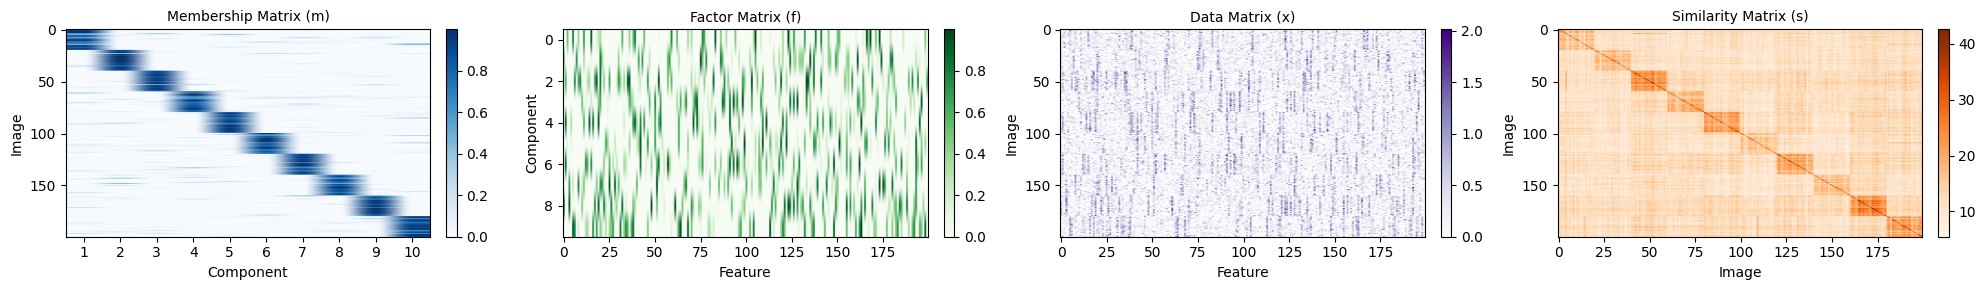

In [1]:
from utils.simulation import generate_simulation_data, SimulationParams
from utils.plotting import plot_simulation

SIMULATION_PARAMS = SimulationParams(
    n=200,
    k=10,
    p=200,
    snr=0.5,
    primary_concentration=5.0,
    base_concentration=0.1,
    sparsity=0.7,
)

X, M, F, S = generate_simulation_data(SIMULATION_PARAMS)

fig = plot_simulation(X, M, F, S)


In [11]:
from models.admm import ADMM

model = ADMM(
    rank=10,
    max_outer=1000,
    max_inner=1,
    tol=0.0,
    verbose=True,
    init="random_sqrt",
)

w = model.fit_transform(S)


In [13]:
from utils.helpers import compute_metrics


true_labels = M.argmax(axis=1)
predicted_labels = w.argmax(axis=1)

metrics = compute_metrics(true_labels, predicted_labels)

metrics


(0.8622924541108837,
 0.9031579863828154,
 np.float64(0.935),
 np.float64(0.09796013763057487))

In [5]:
import numpy as np
from utils.helpers import map_labels_with_hungarian

predicted_clusters = np.argmax(w, 1)
true_labels = np.argmax(M, axis=1)
matches = map_labels_with_hungarian(true_labels, predicted_clusters)

print("accuracy", np.sum(matches == true_labels) / len(true_labels))


accuracy 0.995


In [42]:
df = pd.read_csv("../results/simulated_clustering.csv")
df


,SNR,Seed,Model,ARI,NMI,Purity,Entropy
0,0.0,0,NMF,0.000415,0.094831,0.210,9.053171e-01
1,0.0,0,SNMF,-0.000192,0.101451,0.220,8.989358e-01
2,0.0,1,NMF,-0.005261,0.082454,0.200,9.176530e-01
3,0.0,1,SNMF,-0.002207,0.100258,0.205,8.999217e-01
4,0.0,2,NMF,-0.004366,0.093249,0.200,9.066983e-01
...,...,...,...,...,...,...,...
215,1.0,7,SNMF,0.966582,0.976982,0.985,2.328322e-02
216,1.0,8,NMF,0.977614,0.982700,0.990,1.724281e-02
217,1.0,8,SNMF,0.955819,0.965513,0.980,3.447991e-02
218,1.0,9,NMF,1.000000,1.000000,1.000,-4.125798e-11


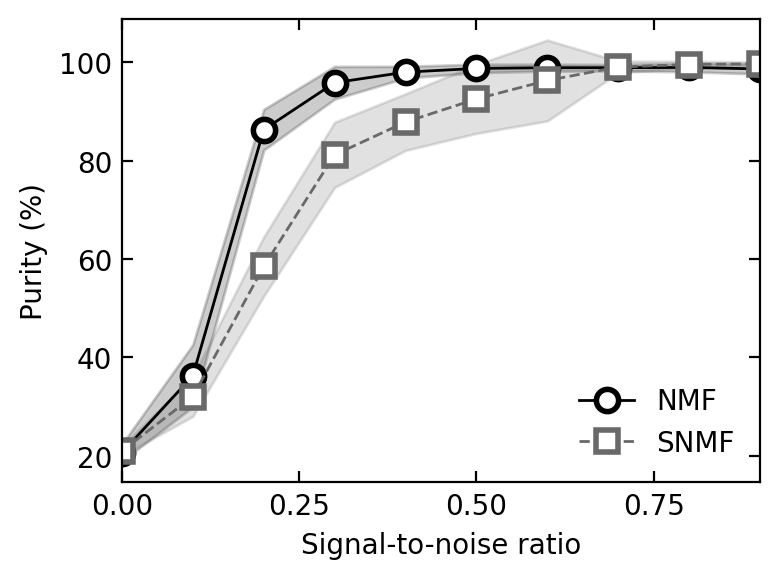

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# Define black and white styling
bw_colors = {
    "NMF": "black",
    "SNMF": "dimgray",
}
bw_styles = {
    "NMF": ("-", "o"),
    "SNMF": ("--", "s"),
}


df = pd.read_csv("../results/simulated_clustering.csv")

# Purity plot with shaded variance
plt.figure(figsize=(4, 3), dpi=200)

# Calculate mean and standard deviation for each SNR/Model combination
purity_stats = df.groupby(["SNR", "Model"])["Purity"].agg(["mean", "std"]).reset_index()

# Convert purity to percentage
purity_stats["mean"] = purity_stats["mean"] * 100
purity_stats["std"] = purity_stats["std"] * 100

for model in purity_stats["Model"].unique():
    model_df = purity_stats[purity_stats["Model"] == model]
    linestyle, marker = bw_styles.get(model, ("-", "o"))
    color = bw_colors.get(model, "black")

    # Plot the main line
    plt.plot(
        model_df["SNR"],
        model_df["mean"],
        label=model,
        color=color,
        linestyle=linestyle,
        marker=marker,
        linewidth=1.0,
        markersize=8,
        markerfacecolor="white",
        markeredgewidth=2,
    )

    # Add shaded variance interval
    plt.fill_between(
        model_df["SNR"],
        model_df["mean"] - model_df["std"],
        model_df["mean"] + model_df["std"],
        color=color,
        alpha=0.2,
    )

plt.xlabel("Signal-to-noise ratio", fontsize=10)
plt.ylabel("Purity (%)", fontsize=10)
plt.legend(fontsize=10, frameon=False)
plt.xlim(0, purity_stats["SNR"].max())

# Use MaxNLocator to automatically place 4 ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=4))

plt.tick_params(
    direction="in",
    top=True,
    right=True,
    which="both",
    labelsize=10,
    length=4,
)
plt.tight_layout()
plt.show()


In [49]:
df = pd.read_csv("../results/simulated_clustering.csv")
df


,SNR,Seed,Model,ARI,NMI,Purity,Entropy
0,0.0,0,NMF,-0.002572,0.108326,0.195,0.904361
1,0.0,0,SNMF,-0.005158,0.093988,0.200,0.906098
2,0.0,1,NMF,-0.000467,0.090665,0.170,0.919459
3,0.0,1,SNMF,0.006579,0.117569,0.225,0.882631
4,0.0,2,NMF,-0.004418,0.082587,0.175,0.926376
...,...,...,...,...,...,...,...
215,1.0,7,SNMF,0.966582,0.976982,0.985,0.023283
216,1.0,8,NMF,0.901012,0.925295,0.955,0.075601
217,1.0,8,SNMF,0.955819,0.965513,0.980,0.034480
218,1.0,9,NMF,0.977328,0.982645,0.990,0.017460


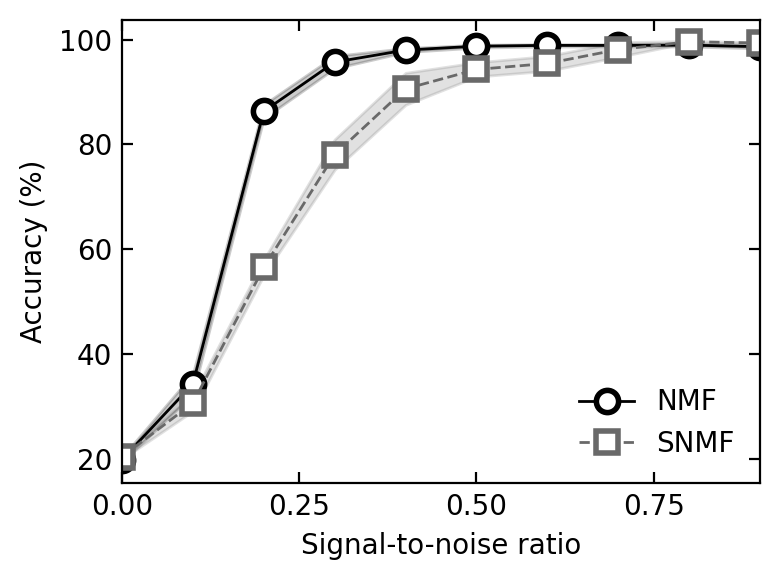

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

df = pd.read_csv("../results/simulated_clustering.csv")

# Define black and white styling
bw_colors = {
    "NMF": "black",
    "SNMF": "dimgray",
}
bw_styles = {
    "NMF": ("-", "o"),
    "SNMF": ("--", "s"),
}

# Purity plot with shaded variance
plt.figure(figsize=(4, 3), dpi=200)

# Calculate mean and standard error for each SNR/Model combination
accuracy_stats = (
    df.groupby(["SNR", "Model"])["Accuracy"].agg(["mean", "std", "count"]).reset_index()
)
accuracy_stats["se"] = accuracy_stats["std"] / np.sqrt(accuracy_stats["count"])

# Convert purity to percentage
accuracy_stats["mean"] = accuracy_stats["mean"] * 100
accuracy_stats["se"] = accuracy_stats["se"] * 100

for model in accuracy_stats["Model"].unique():
    model_df = accuracy_stats[accuracy_stats["Model"] == model]
    linestyle, marker = bw_styles.get(model, ("-", "o"))
    color = bw_colors.get(model, "black")

    # Plot the main line
    plt.plot(
        model_df["SNR"],
        model_df["mean"],
        label=model,
        color=color,
        linestyle=linestyle,
        marker=marker,
        linewidth=1.0,
        markersize=8,
        markerfacecolor="white",
        markeredgewidth=2,
    )

    # Add shaded confidence interval
    plt.fill_between(
        model_df["SNR"],
        model_df["mean"] - model_df["se"],
        model_df["mean"] + model_df["se"],
        color=color,
        alpha=0.2,
    )

plt.xlabel("Signal-to-noise ratio", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)
plt.legend(fontsize=10, frameon=False)
plt.xlim(0, accuracy_stats["SNR"].max())

# Use MaxNLocator to automatically place 4 ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=4))

plt.tick_params(
    direction="in",
    top=True,
    right=True,
    which="both",
    labelsize=10,
    length=4,
)
plt.tight_layout()
plt.show()


In [13]:
from pathlib import Path

# Cell: load ablation results
ablation_path = Path("..") / "results" / "simulated_denoising_ablation" / "ablation.csv"
df_ab = pd.read_csv(ablation_path)

# derive plotting columns and set category order for clean facets
df_ab["AccuracyPct"] = 100.0 * df_ab["Accuracy"]
df_ab["PurityPct"] = 100.0 * df_ab["Purity"]
df_ab["Preproc"] = pd.Categorical(df_ab["Preproc"], ["none", "row_l2"])
df_ab["Diag"] = pd.Categorical(df_ab["Diag"], ["n/a", "keep", "zero", "missing"])

df_ab.head(30)


,SNR,Seed,Model,Preproc,Diag,ARI,NMI,Purity,Entropy,Accuracy,EvarOffdiag,AccuracyPct,PurityPct
0,0.0,0,NMF,none,NaN,0.021257,0.149402,0.225,0.854205,0.210,0.097583,21.0,22.5
1,0.0,0,SNMF,none,keep,0.005689,0.113852,0.215,0.886778,0.210,-6.477514,21.0,21.5
2,0.0,0,SNMF,none,zero,0.003509,0.122669,0.220,0.881325,0.205,-6.322020,20.5,22.0
3,0.0,0,SNMF,none,missing,-0.004848,0.096653,0.195,0.904452,0.185,-6.383134,18.5,19.5
4,0.0,0,SNMF,row_l2,keep,-0.000601,0.103082,0.210,0.897523,0.205,0.058015,20.5,21.0
5,0.0,0,SNMF,row_l2,zero,-0.002472,0.095252,0.210,0.907017,0.200,0.057178,20.0,21.0
6,0.0,0,SNMF,row_l2,missing,-0.003140,0.101985,0.205,0.900660,0.195,0.057500,19.5,20.5
7,0.0,1,NMF,none,NaN,-0.002575,0.105909,0.195,0.895883,0.195,0.113167,19.5,19.5
8,0.0,1,SNMF,none,keep,0.012947,0.127563,0.235,0.872606,0.225,-6.916871,22.5,23.5
9,0.0,1,SNMF,none,zero,-0.000405,0.106819,0.210,0.896835,0.200,-6.748034,20.0,21.0


In [ ]:
# Cell: load ablation and prepare for plotting (broadcast NMF across diag facets)
from pathlib import Path

ablation_path = Path("..") / "results" / "simulated_denoising_ablation" / "ablation.csv"
df_ab = pd.read_csv(ablation_path)

df_ab["AccuracyPct"] = 100.0 * df_ab["Accuracy"]
df_ab["PurityPct"] = 100.0 * df_ab["Purity"]

diag_order = ["keep", "zero", "missing"]
preproc_order = ["none", "row_l2"]

nmf_rows = df_ab[df_ab["Model"] == "NMF"].copy()
nmf_broadcast = pd.concat(
    [nmf_rows.assign(Diag=d) for d in diag_order], ignore_index=True
)

df_snmf = df_ab[df_ab["Model"] == "SNMF"].copy()
df_plot = pd.concat([df_snmf, nmf_broadcast], ignore_index=True)

df_plot["Preproc"] = pd.Categorical(df_plot["Preproc"], preproc_order)
df_plot["Diag"] = pd.Categorical(df_plot["Diag"], diag_order)


AttributeError: 'FacetGrid' object has no attribute 'texts'

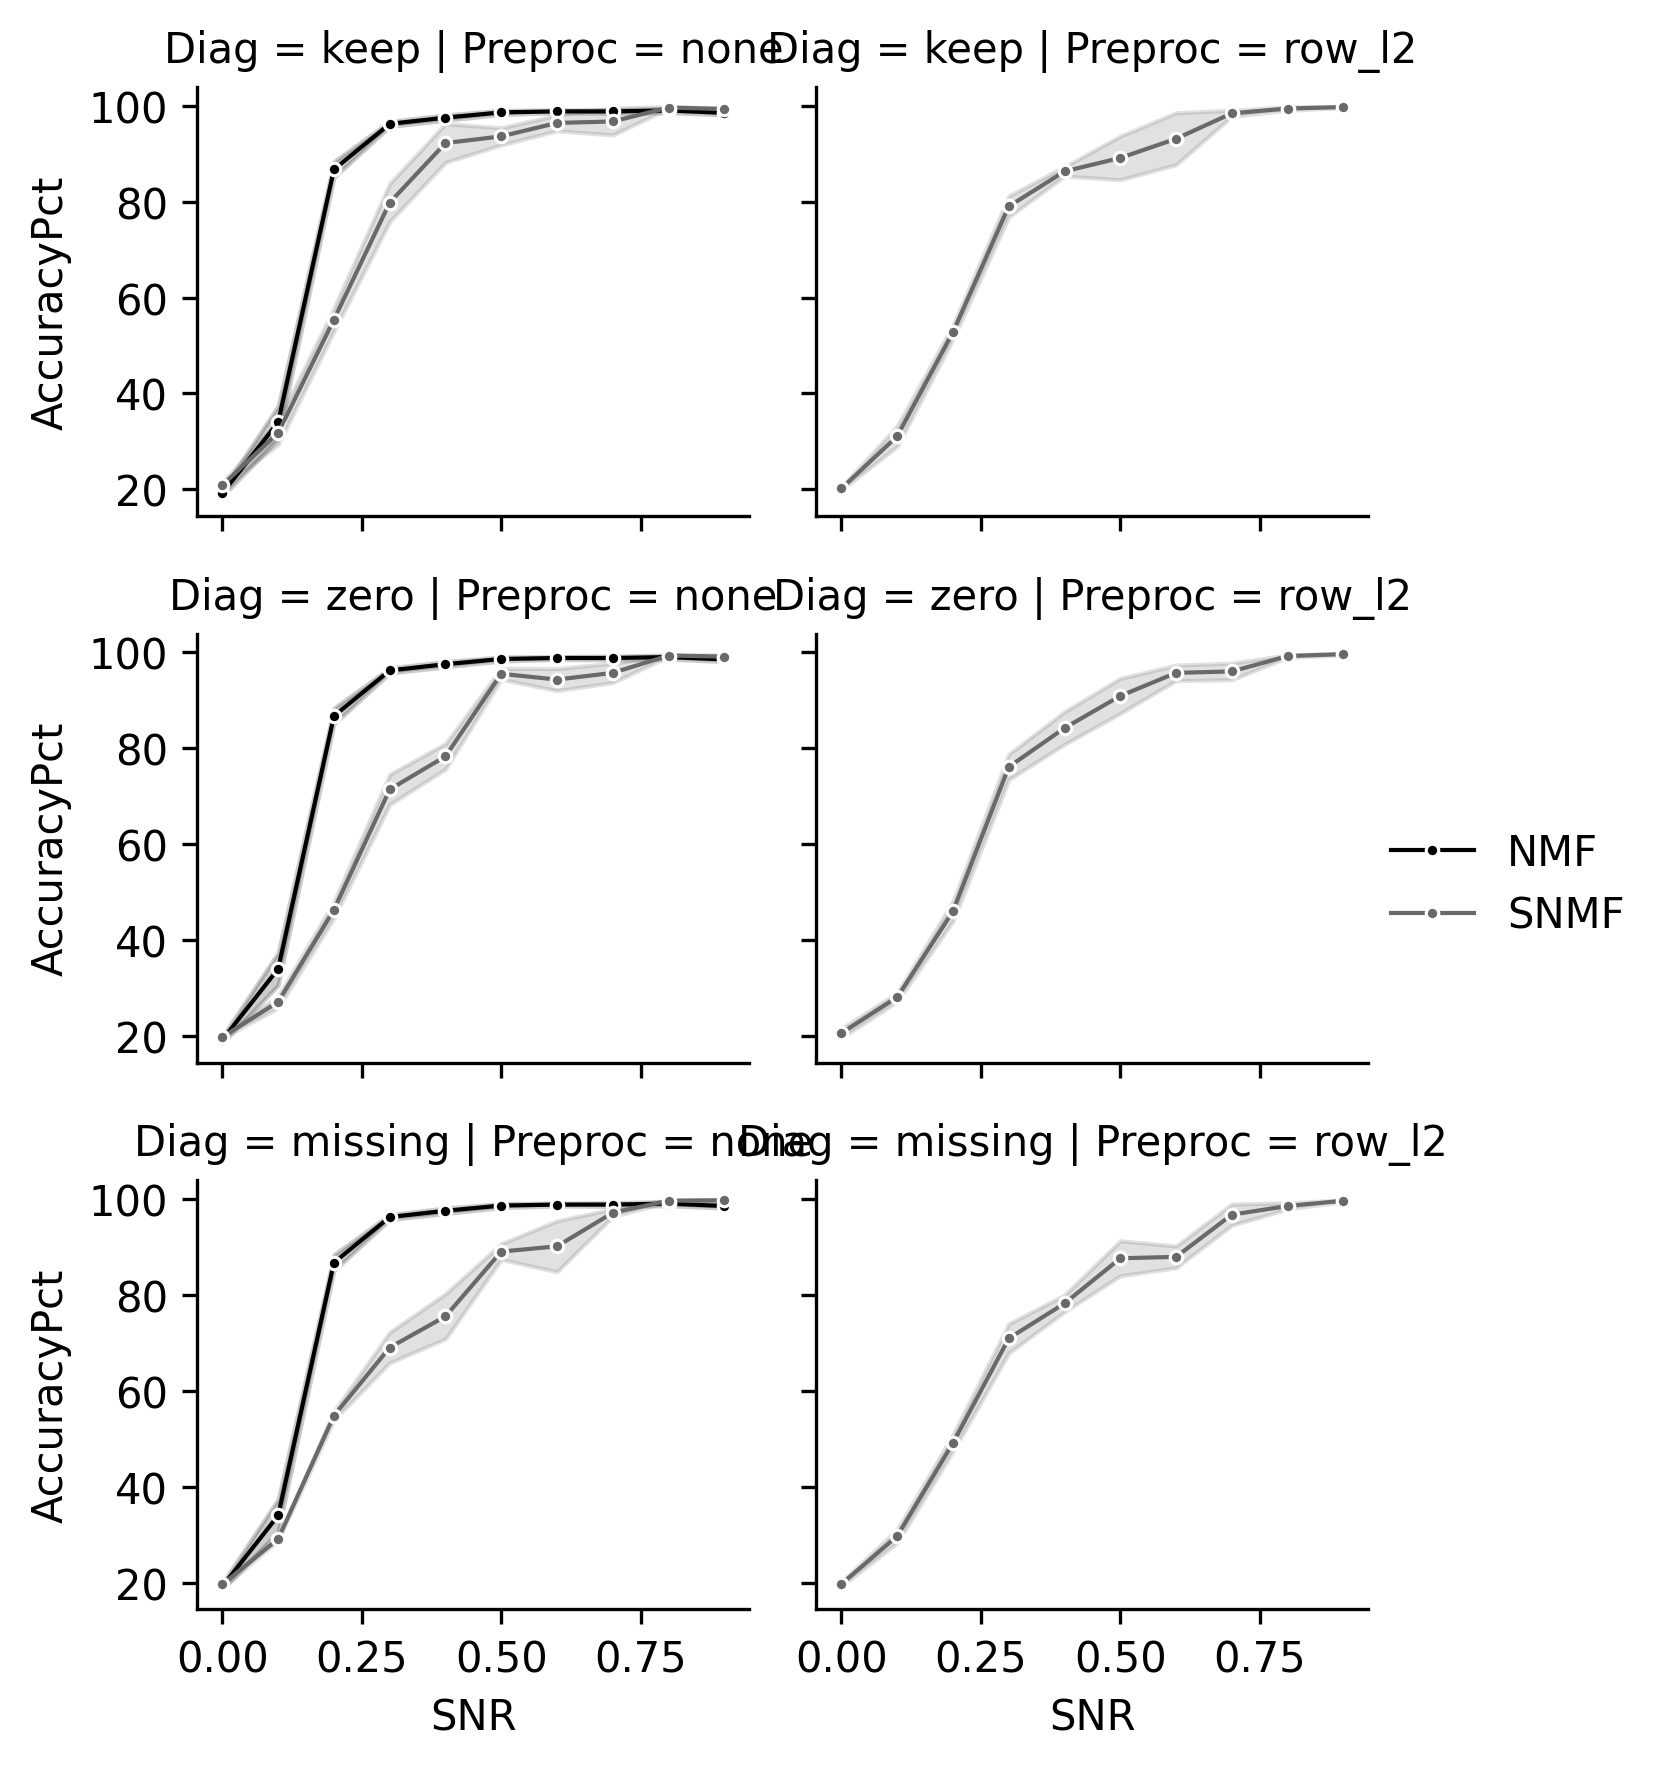

In [ ]:
# Cell: accuracy vs snr
plt.rcParams["figure.dpi"] = 300
palette = {"NMF": "black", "SNMF": "dimgray"}

g = sns.FacetGrid(
    df_plot, col="Preproc", row="Diag", height=2.0, aspect=1.2, sharex=True, sharey=True
)
g.map_dataframe(
    sns.lineplot,
    x="SNR",
    y="AccuracyPct",
    hue="Model",
    hue_order=["NMF", "SNMF"],
    palette=palette,
    errorbar="se",
    linewidth=1.0,
    marker="o",
    markersize=3,
)
leg = g.add_legend()
if leg is not None:
    # leg.set_title(None)
    for t in leg.texts:
        t.set_fontsize(7)

g.set_axis_labels("Signal-to-noise ratio", "Accuracy (percent)")
for ax in g.axes.flat:
    ax.tick_params(labelsize=7)
    ax.set_xlabel("Signal-to-noise ratio", fontsize=7)
    ax.set_ylabel("Accuracy (percent)", fontsize=7)
plt.tight_layout()
plt.show()


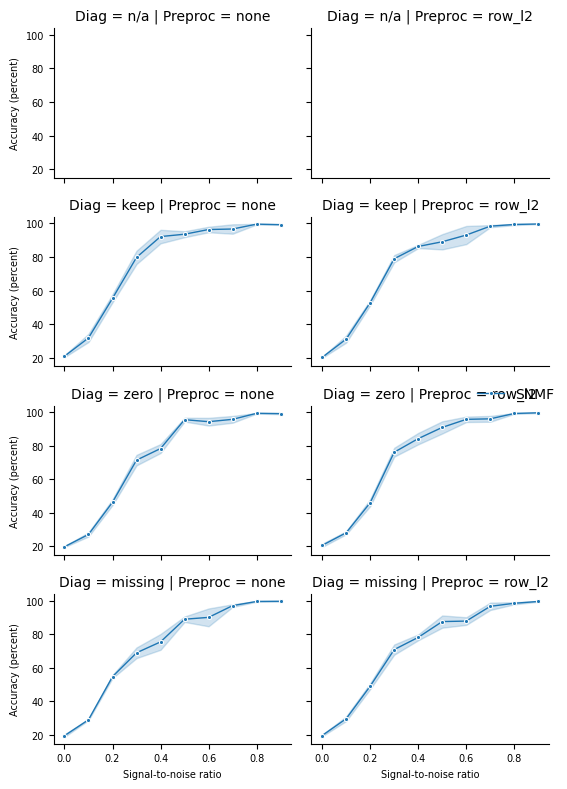

In [ ]:
# Cell: accuracy vs SNR (percent), faceted by preprocessing and diagonal handling
g = sns.FacetGrid(
    df_ab,
    col="Preproc",
    row="Diag",
    height=2.0,
    aspect=1.2,
    sharex=True,
    sharey=True,
    margin_titles=False,
)
g.map_dataframe(
    sns.lineplot,
    x="SNR",
    y="AccuracyPct",
    hue="Model",
    errorbar="se",
    linewidth=1.0,
    marker="o",
    markersize=3,
)
leg = g.add_legend()


g.set_axis_labels("Signal-to-noise ratio", "Accuracy (percent)")
for ax in g.axes.flat:
    ax.tick_params(labelsize=7)
    ax.set_xlabel("Signal-to-noise ratio", fontsize=7)
    ax.set_ylabel("Accuracy (percent)", fontsize=7)
plt.tight_layout()
plt.show()


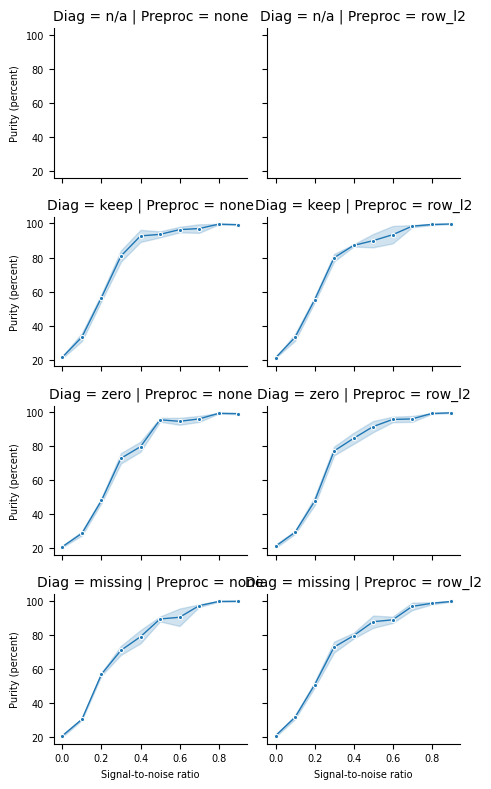

In [ ]:
# Cell: purity vs SNR (percent), faceted by preprocessing and diagonal handling
g = sns.FacetGrid(
    df_ab,
    col="Preproc",
    row="Diag",
    height=2.0,
    aspect=1.2,
    sharex=True,
    sharey=True,
    margin_titles=False,
)
g.map_dataframe(
    sns.lineplot,
    x="SNR",
    y="PurityPct",
    hue="Model",
    errorbar="se",
    linewidth=1.0,
    marker="o",
    markersize=3,
)

g.set_axis_labels("Signal-to-noise ratio", "Purity (percent)")
for ax in g.axes.flat:
    ax.tick_params(labelsize=7)
    ax.set_xlabel("Signal-to-noise ratio", fontsize=7)
    ax.set_ylabel("Purity (percent)", fontsize=7)
plt.tight_layout()
plt.show()
